# Welcome to the Prototype

Table of Contents:
1) **Introduction**<br>
2) **Datasets**<br>
    2.1) Synthetic Dataset<br>
    2.2) 30 Years of European Wind Generation <br>
3) **Transformer Frameworks**<br>
    3.1) Informer<br>
    3.2) Autoformer<br>
    3.4) Pyraformer<br>
    3.5) Model Summaries<br>
4) **Forecasting Results**<br>
    4.1) 24-Hour Windows (Day)<br>
    4.2) 168-Hour Windows (Week)<br>
    4.3) 720-Hour Windows (Month)<br>
5) **Summary**

## **1. Introduction**

Some introduction

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import torch

In [2]:
# MSE function 
def MSE(pred, true):
    return np.mean((pred-true)**2)

## **2. Datasets**

### **2.1) Synthetic Data**

Below we generate two synthetic datasets that emulate energy data (consumption, load, etc.) patterns using a linear combination of three sine functions.

The code for the data generator is a slight amendment of the synthetic generator used in [[1]](https://repositum.tuwien.at/handle/20.500.12708/135874).

The equation for the synthetic time series is defined as: 
$$f(t) = \beta_0 = \beta_1 sin(\frac{2\pi}{24}t) + \beta_2 sin(\frac{2\pi}{168}t) + \beta_3 sin(\frac{2\pi}{720}t),$$
where $\beta_1$, $\beta_2$, and $\beta_3$ are uniformly sampled for each point in time $t$ from $[5,10]$, while $\beta_0$ follows a Gaussian process with a polynomially decaying covariance function $\Sigma_{t_1, t_2} = |t_1 - t_2|^{-1}$, where $\Sigma_{t_1} = \Sigma_{t_2} = 1$ and $t_1$ and $t_2$ are arbitrary time stamps.

The synthetic dataset, with the decaying covariance function, is supposed to model long-range dependencies over $24$, $168$, and $720$ hour ranges.

At the initial stage, for ease of implementation, we will generate two synthetic time series with a sequence length of 17,420 - which is roughly two years of hourly data.

**Important to Note:**
Due to the aforementioned specifications of the data generator, re-running this section will lead to the generation of two new time series, replacing the existing datasets.

In [ ]:
from data_generator import SynthesisTS

In [ ]:
# Initialize data synthesizer
SynthMaker = SynthesisTS(series_amount=1, seq_len=17420)

In [ ]:
# Generate first synthetic time series
df1 = SynthMaker.synthesize_single_series()

The obtained dataset is a univariate time series that comes with an arbitrarily picked date-time index, which later gets used in Transformer time series frameworks for time feature embedding.

In [ ]:
df1.head()

,date,TARGET
0,2022-01-25 22:00:00,-14.648879
1,2022-01-25 23:00:00,-11.896418
2,2022-01-26 00:00:00,-10.142491
3,2022-01-26 01:00:00,-8.443276
4,2022-01-26 02:00:00,-5.100413


In [ ]:
# Descriptive statistics
df1.describe()

,TARGET
count,17420.000000
mean,-0.028227
std,8.832361
min,-22.467177
25%,-6.258678
50%,0.045538
75%,6.217201
max,22.536278


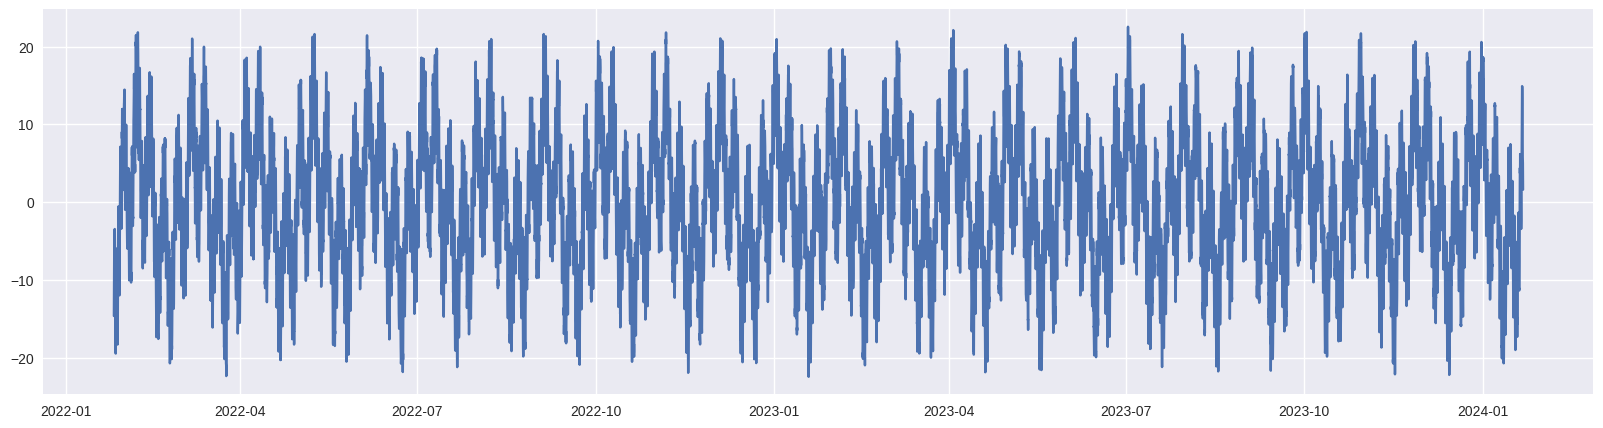

In [ ]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df1['date'], df1['TARGET'])
plt.show()

In [ ]:
# Generate second time series
df2 = SynthMaker.synthesize_single_series()

In [ ]:
df2.head()

,date,TARGET
0,2022-01-04 20:00:00,-2.771159
1,2022-01-04 21:00:00,-3.925664
2,2022-01-04 22:00:00,-3.202413
3,2022-01-04 23:00:00,-0.233802
4,2022-01-05 00:00:00,0.627382


In [ ]:
# Descriptive statistics
df2.describe()

,TARGET
count,17420.000000
mean,0.086133
std,9.459860
min,-24.797278
25%,-6.713751
50%,0.120974
75%,6.854593
max,24.699640


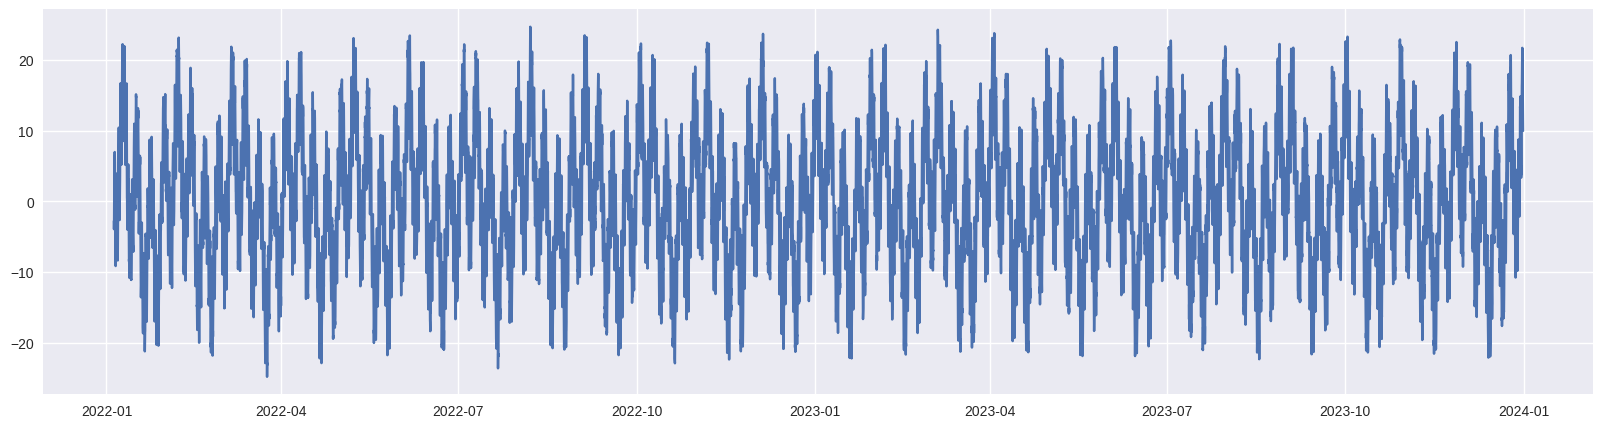

In [ ]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['TARGET'])
plt.show()

In [ ]:
# Save
df1.to_csv('SYNTHDataset/SYNTHh1.csv', index=False)
df2.to_csv('SYNTHDataset/SYNTHh2.csv', index=False)

### **2.2) 30 Years of European Wind Generation**

This dataset contains hourly estimates of an area's energy potential for 1986-2015 as a percentage of a power plant's maximum output.
The data is available at both the national level with and the NUTS 2 level. The NUTS 2 system divides the EU into 276 statistical units. The national level data contains observations from 29 european countries, such as United Kingdom,Germany,Spain.
For the purpose of this prototype, we chose Germany data as a univariate data input to our models

In [8]:
df3 = pd.read_csv('WINDataset/DEWINDh_small.csv')
df3.head()

,date,TARGET
0,2014-01-05 04:00:00,1.000000e-10
1,2014-01-05 05:00:00,1.000000e-10
2,2014-01-05 06:00:00,1.000000e-10
3,2014-01-05 07:00:00,1.000000e-10
4,2014-01-05 08:00:00,3.851301e-02


In [10]:
# Descriptive statistics
df3.describe()

,TARGET
count,1.742000e+04
mean,1.009882e-01
std,1.531910e-01
min,1.000000e-10
25%,1.000000e-10
50%,2.592006e-03
75%,1.617573e-01
max,6.647579e-01


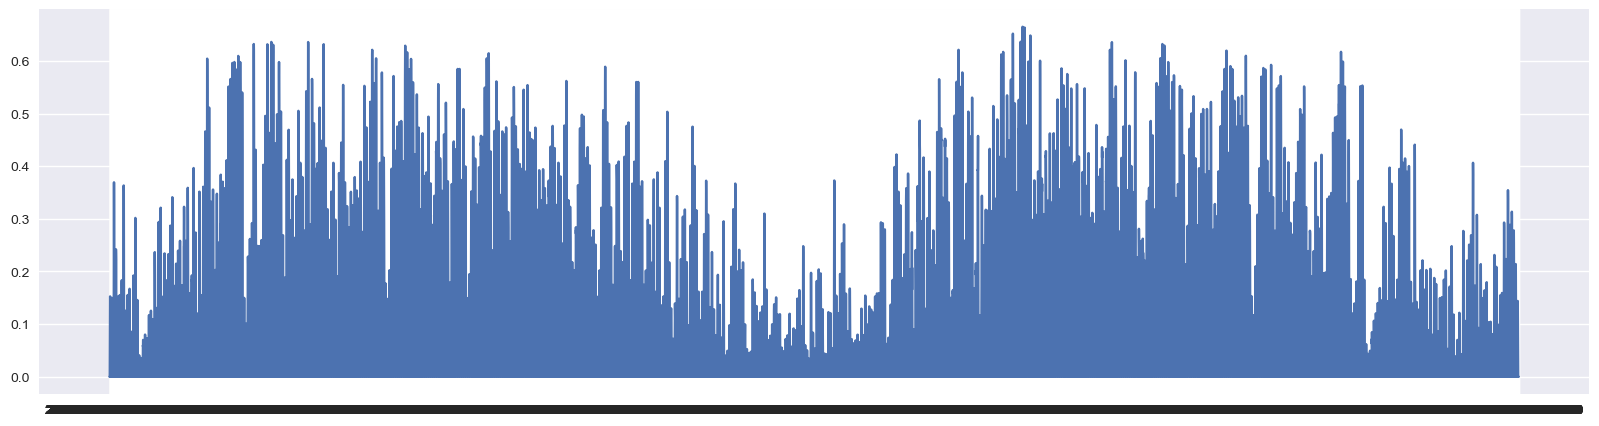

In [11]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df3['date'], df2['TARGET'])
plt.show()

## **3. Transformer Frameworks**

### **3.1) Informer**

Informer [[2]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) outlines three existing limitations of the vanilla Transformer when tasked with long sequence time-series forecasting (LSTF):
- $\mathcal{O}(n^2)$ - quadratic computation of the canonical dot-product self-attention per layer.
- $\mathcal{O}(J \cdot n^2)$ - memory bottleneck when stacking $J$ encoder/decoder layers.
- Speed plunge - Vanilla Transformer struggles with long outputs as decoding happens step-by-step.

To overcome the issue, the following proposals are made:
- $ProbSparse$ self-attention mechanism to replace the canonical self-attention, achieving $\mathcal{O}(n \text{log} n)$ time complexity as well as $\mathcal{O}(n \text{log} n)$ memory usage.
- Self-attention distilling to privilege dominating attention in $J$ layers reducing the total space complexity to $\mathcal{O}((2 - \epsilon)n \text{log} n)$
- Generative-style inference using vanilla decoder architecture to obtain long-sequence output in one go.

- - -

**$ProbSparse$ Self-Attention**

[[2]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) discusses the dot-product attention:
$$
\mathcal{A}(Q, K, V) = \text{softmax} \left( \frac{QK^{T}}{\sqrt{d}} \right),
$$
where $Q \in \mathbb{R}^{L_{Q} \times d}$, $K \in \mathbb{R}^{L_{K} \times d}$, $V \in \mathbb{R}^{L_{V} \times d}$ and $d$ is the input dimension, pointing out that if we let $q_{i}, k_{i}, v_{i}$ stand for the $i$-th row in $Q, K, V$ respectively, the $i$-th query's attention can be defined as a kernel smoother in a probability form:
$$
\mathcal{A}(q_{i}, K, V) = \sum_{j} \frac{k(q_i, k_j)}{\sum_{l}k(q_i, k_l)}v_j = \mathbb{E}_{p(k_j|q_i)}[v_j],
$$
where $p(k_j|q_i) = k(q_i, k_j)/\sum_{l}k(q_i, k_l)$ and $k(q_i, k_j)$ selects the asymmetric exponential kernel $\text{exp}(q_{i}k_{j}^{T}/\sqrt{d}).$

The authors argue that the $i$-th query's attention with all keys defined as probability $p(k_j|q_i)$ would follow a uniform distribution if not for the dominant dot-product pairs which encourage the probability distribution away from a uniform distribution. If the probability distribution was close to a uniform distribution $p(k_j|q_i)=1/L_K$, the self-attention would just become a trivial sum of values $V$. 

In this regard, the authors propose a measure of "likeness" between distribution $p$ and $q$ to identify the dominant dot-product pairs. For this purpose, they use Kullback-Leibner Divergence:
$$
KL(q||p) = \text{ln} \sum_{l=1}^{L_K}e^{\frac{q_{i} k_{l}^T}{\sqrt{d}}} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}} - \text{ln}L_K
$$

Dropping the constant, they formulate $i$-th query's sparsity measurement:
$$
M(q_i, K) = \text{ln} \sum_{l=1}^{L_K}e^{\frac{q_{i} k_{l}^T}{\sqrt{d}}} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}},
$$
where the first term is the Log-Sum-Exp of $q_i$ on all keys and the second term is the arithmetic mean on them. According to the authors, if a query gains a larger measurement, its attention probability is more "diverse" and has a higher chance of containing dominating dot-product pairs.

Based on this the definition of the $ProbSparse$ Self-Attention is offered:
$$
\mathcal{A}(Q, K, V) = \text{softmax} \left( \frac{\bar{Q}K^{T}}{\sqrt{d}} \right),
$$
where $\bar{Q}$ is a sparse matrix hat only contains top-$u$ queries under the measurement $M(q,K)$. $u$ is controlled by a sampling factor $c$ s.t. $u = c \cdot \text{ln}L_Q.$ The papers however argues that the sparsity measurement operation is $\mathcal{O}(n^2)$ n its nature and the Log-Sum-Exp operation can run into numerical stability issues. Hence instead an approximation of the sparsity measurement is used as follows:
$$
\bar{M}(q_i, K) = \max_{j}\{\frac{q_{i} k_{l}^T}{\sqrt{d}}\} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}},
$$
where they sample $U = L_K \text{ln} L_Q$ dot product pairs to calculate the \bar{M}(q_i, K) and select from it the sparse top-$u$ queries for $\bar{Q}$. This leads to the $\mathcal{O}(L\text{ln}L)$ space and time complexity given that $L_Q=L_K=L$.

- - -

**Self-Attention Distilling**

In the encoder, Informer [[2]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) argues the $ProbSparse$ self-attention mechanism results in redundant combinations of value $V$ in the feature map. To combat this, a distillation operation is proposed. From $j$-th layer (attention block) into $(j+1)$-th layer, the distillation is as follows:
$$
X_{j+1}^{t} = \text{MaxPool} \left( \text{ELU} \left( \text{Conv1d} \left( [X^{t}_{j}]_{AB} \right) \right)\right)
,$$
where $[\cdot]_{AB}$ stands for the attention block, $\text{Conv1d}$ for one dimensional convolution with kernel size of 3 along $t$, $\text{ELU}$ for the exponential linear unit activation function and $\text{MaxPool}$ for max-pooling with a stride of 2. 

With this operation, the authors note that overall memory usage is reduced to $\mathcal{O}((2 - \epsilon)L \text{log} L)$, where $\epsilon$ stands for a small number.

- - -

### **3.2) Autoformer**

### **3.4) Pyraformer**

### **3.5) Model Summaries**

| **Framework** | Encoder Novelty | Decoder Novelty | Architecture Novelty | Prediction Windows (Hourly) | Window Stride | Encoder Input Length | Decoder Input Length | Scaling | Optimizer | Learning Rate | Loss |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| **Informer** | $ProbSparse$ Self-Attention| Generative Inference | Self-Attention Distilling via $\text{Conv1d}$ and $\text{MaxPool}$ | 24 (day), 168 (week), 720 (month) | 1 | 96 | $48 + \text{prediction window size}$ | Standard | Adam | $1e-4$, decaying by half next epoch | MSE |
| **Autoformer** |  |  |
| **Pyraformer** |  | |

## **4. Forecasting Results**

### **4.1) 24-Hour Windows (Day)**

Predictions and true values are numpy arrays of shape `number_of_windows, number_of_observations, number_of_targets` which in case of both synthetic and wind data will be (2848, 24, 1). 

Metrics is an `np.array([mae, mse, rmse, mape, mspe]`



In [8]:
# Load Informer Results for 24-Hour Synthetic Data
informer_synthpreds_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Informer Results for 24-hour Wind Data
informer_windpreds_24 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_24 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 24-Hour Synthetic Data
autoformer_synthpreds_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Autoformer Results for 24-hour Wind Data
autoformer_windpreds_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results


Below we compute $\text{MSE}$ scores per each 24-hour prediction window for forecasts on both datasets.

In [9]:
# Synthetic data
informer_errors_synth_24 = np.array([MSE(informer_synthpreds_24[i, :, :], informer_synthtrue_24 [i, :, :]) for i in range(len(informer_synthpreds_24))])
autoformer_errors_synth_24 = np.array([MSE(autoformer_synthpreds_24[i, :, :], autoformer_synthtrue_24[i, :, :]) for i in range(len(autoformer_synthpreds_24))])
#pyraformer_errors_synth_24 = 

# Wind data
informer_errors_wind_24 = np.array([MSE(informer_windpreds_24[i, :, :], informer_windtrue_24[i, :, :]) for i in range(len(informer_windpreds_24))])
autoformer_errors_wind_24 = np.array([MSE(autoformer_windpreds_24[i, :, :], autoformer_windtrue_24[i, :, :]) for i in range(len(autoformer_windpreds_24))])
#pyraformer_errors_synth_24 =

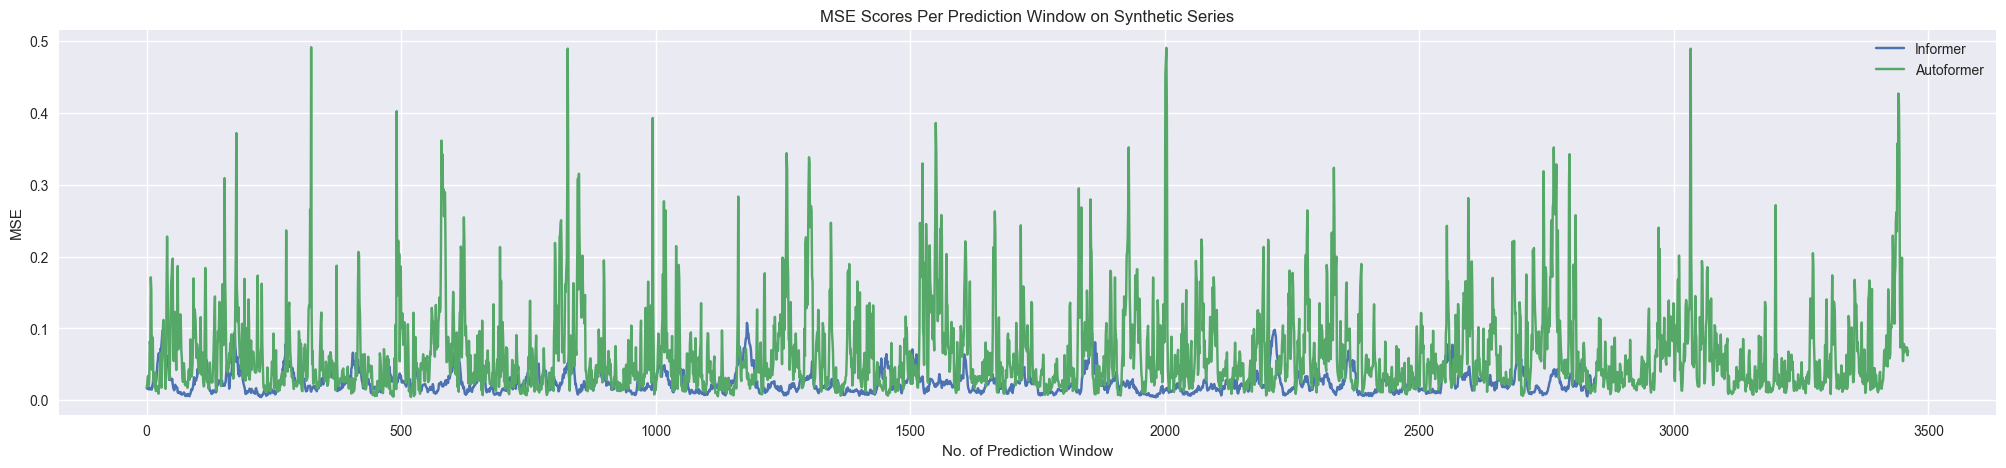

In [10]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_24, label='Informer')
plt.plot(autoformer_errors_synth_24, label='Autoformer')
#plt.plot(pyraformer_errors_synth_24, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

In [11]:
len(autoformer_synthpreds_24)

3461

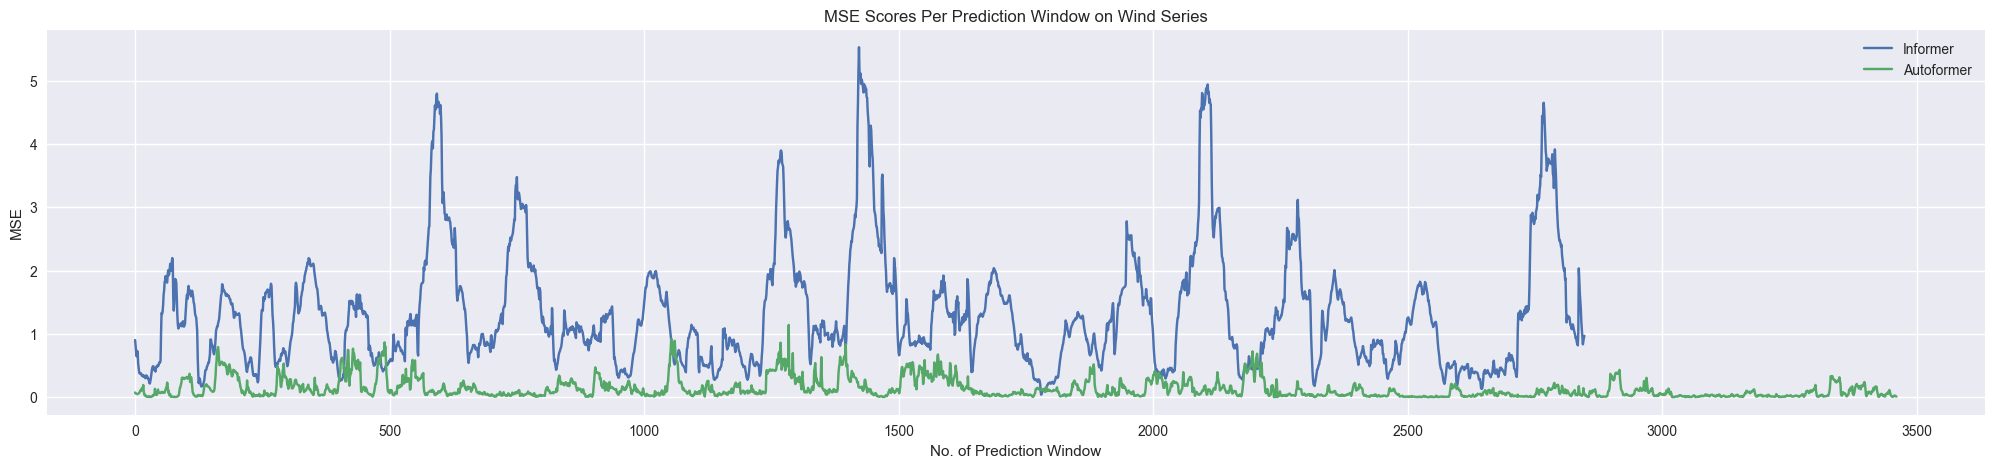

In [12]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_24, label='Informer')
plt.plot(autoformer_errors_wind_24, label='Autoformer')
#plt.plot(pyraformer_errors_wind_24, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

### **4.2) 168-Hour Windows (Week)**

In [13]:
# Load Informer Results for 168-Hour Synthetic Data
informer_synthpreds_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Informer Results for 168-hour Wind Data
informer_windpreds_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 168-Hour Synthetic Data
autoformer_synthpreds_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Autoformer Results for 168-hour Wind Data
autoformer_windpreds_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results


Below we compute $\text{MSE}$ scores per each 168-hour prediction window for forecasts on both datasets.

In [14]:
# Synthetic data
informer_errors_synth_168 = np.array([MSE(informer_synthpreds_168[i, :, :], informer_synthtrue_168[i, :, :]) for i in range(len(informer_synthpreds_168))])
autoformer_errors_synth_168 = np.array([MSE(autoformer_synthpreds_168[i, :, :],autoformer_synthtrue_168[i, :, :]) for i in range(len(autoformer_synthpreds_168))])
#pyraformer_errors_synth_168 = 

# Wind data
informer_errors_wind_168 = np.array([MSE(informer_windpreds_168[i, :, :], informer_windtrue_168[i, :, :]) for i in range(len(informer_windpreds_168))])
autoformer_errors_wind_168 = np.array([MSE(autoformer_windpreds_168[i, :, :], autoformer_windtrue_168[i, :, :]) for i in range(len(autoformer_windpreds_168))])
#pyraformer_errors_wind_168 =

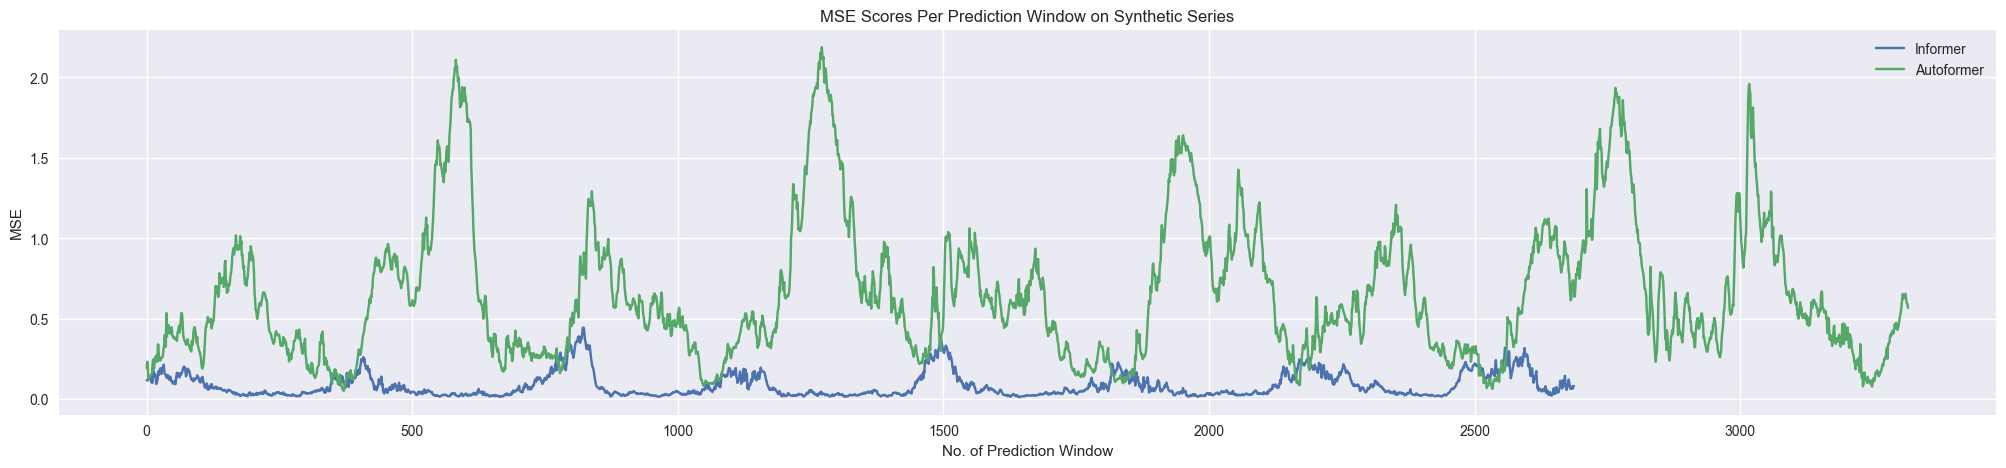

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_168, label='Informer')
plt.plot(autoformer_errors_synth_168, label='Autoformer')
#plt.plot(pyraformer_errors_synth_168, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

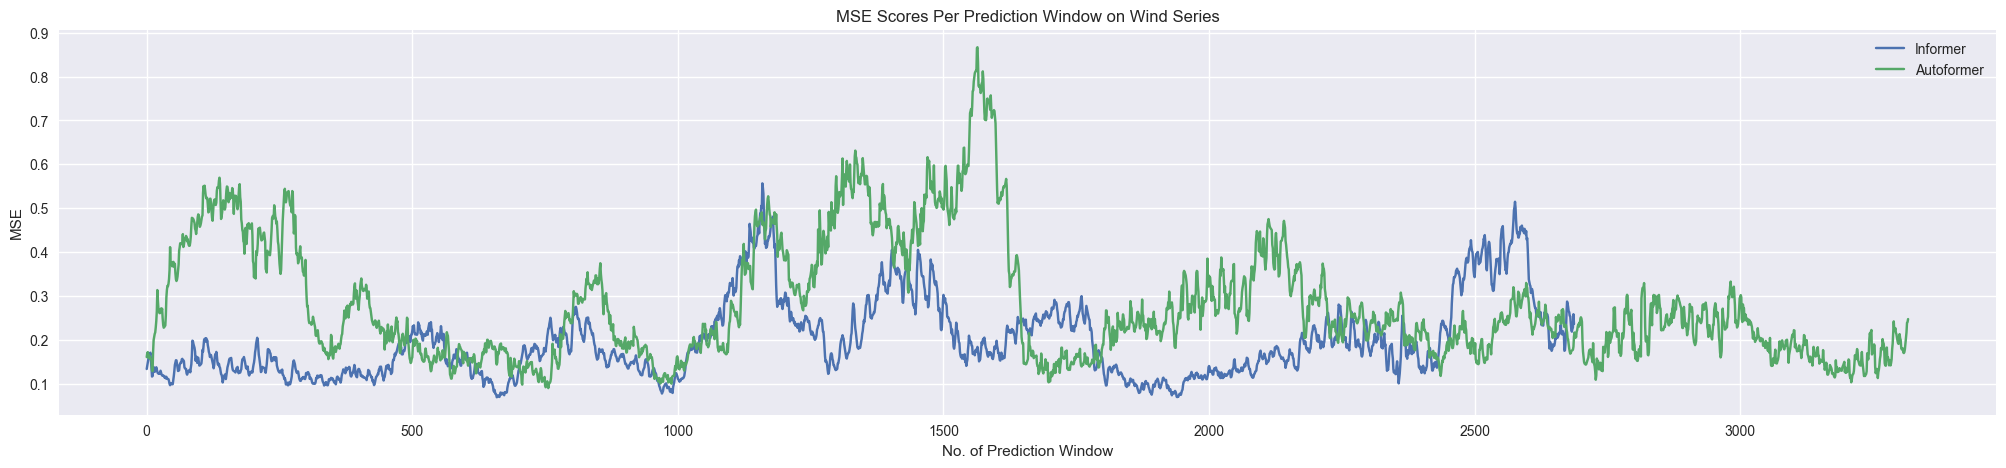

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_168, label='Informer')
plt.plot(autoformer_errors_wind_168, label='Autoformer')
#plt.plot(pyraformer_errors_wind_168, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

### **4.3) 720-Hour Windows (Month)**

In [17]:
# Load Informer Results for 720-Hour Synthetic Data
informer_synthpreds_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Informer Results for 720-hour Wind Data
informer_windpreds_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 720-Hour Synthetic Data
autoformer_synthpreds_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Autoformer Results for 168-hour Wind Data
autoformer_windpreds_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')


# Load Pyraformer Results


Below we compute $\text{MSE}$ scores per each 168-hour prediction window for forecasts on both datasets.

In [18]:
# Synthetic data
informer_errors_synth_720 = np.array([MSE(informer_synthpreds_720[i, :, :], informer_synthtrue_720[i, :, :]) for i in range(len(informer_synthpreds_720))])
autoformer_errors_synth_720 = np.array([MSE(autoformer_synthpreds_720[i, :, :], autoformer_synthtrue_720[i, :, :]) for i in range(len(autoformer_synthpreds_720))])
#pyraformer_errors_synth_720 = 

# Wind data
informer_errors_wind_720 = np.array([MSE(informer_windpreds_720[i, :, :], informer_windtrue_720[i, :, :]) for i in range(len(informer_windpreds_720))])
autoformer_errors_wind_720 = np.array([MSE(autoformer_windpreds_720[i, :, :], autoformer_windtrue_720[i, :, :]) for i in range(len(autoformer_windpreds_720))])
#pyraformer_errors_wind_720 =

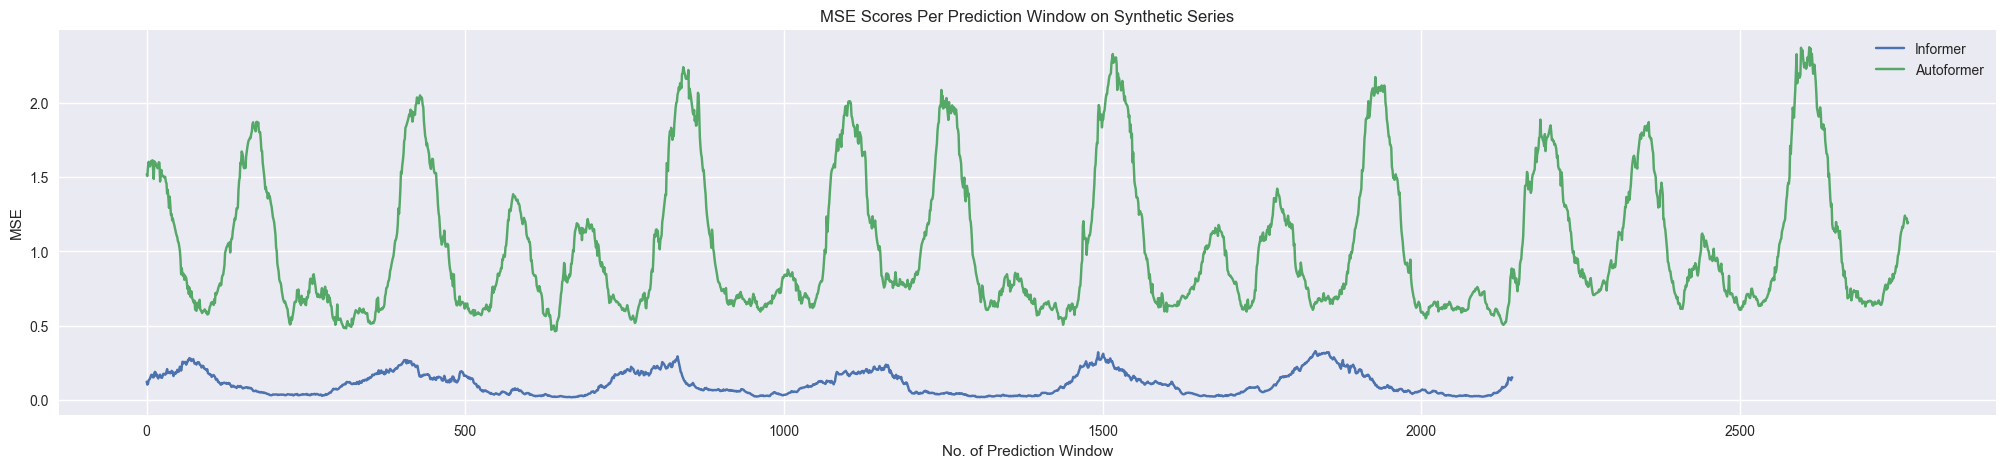

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_720, label='Informer')
plt.plot(autoformer_errors_synth_720, label='Autoformer')
#plt.plot(pyraformer_errors_synth_720, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

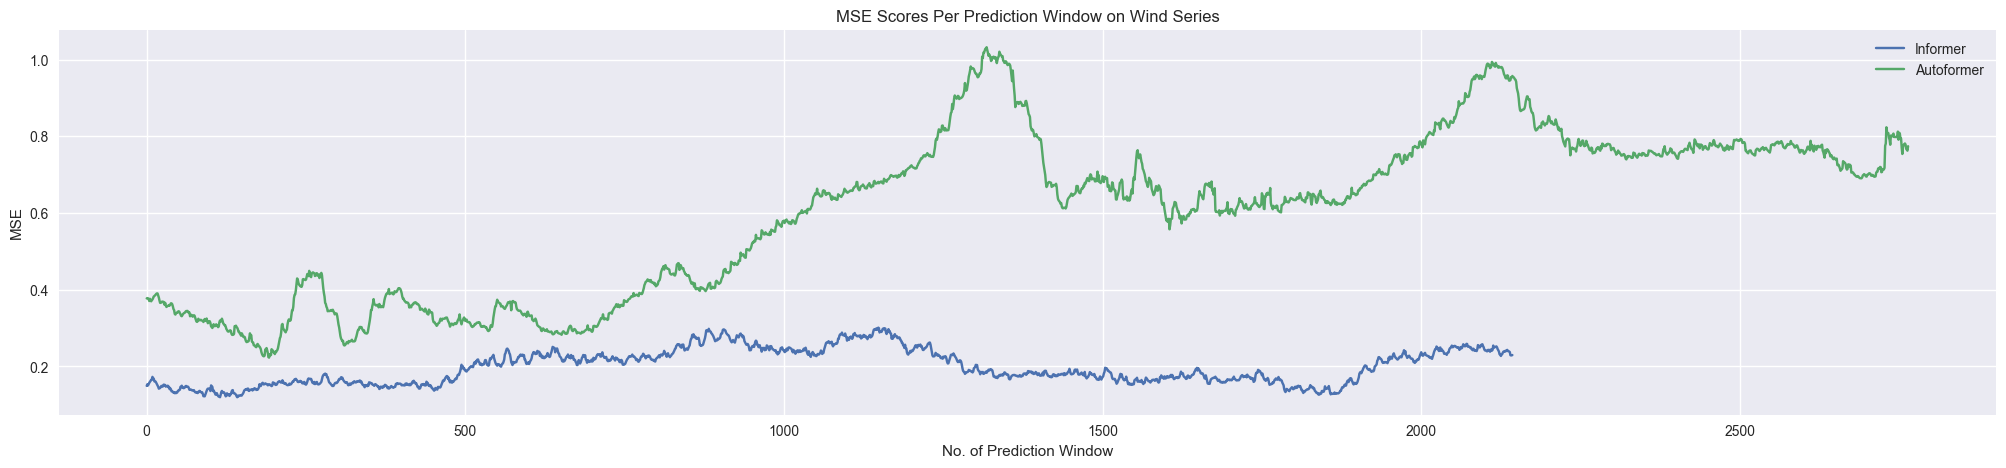

In [20]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_720, label='Informer')
plt.plot(autoformer_errors_wind_720, label='Autoformer')
#plt.plot(pyraformer_errors_wind_720, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series')
plt.xlabel('No. of Prediction Window')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.close()

## **5. Summary**

Some analysis

In [23]:
errors_synthetic_informer = [informer_synthmetrics_24[1], informer_synthmetrics_168[1], informer_synthmetrics_720[1]]
errors_synthetic_autoformer = [autoformer_synthmetrics_24[1], autoformer_synthmetrics_168[1], autoformer_synthmetrics_720[1]]
errors_synthetic_pyraformer = [0.2472,0.2770,0.2305]
windows = ['24', '168', '720']

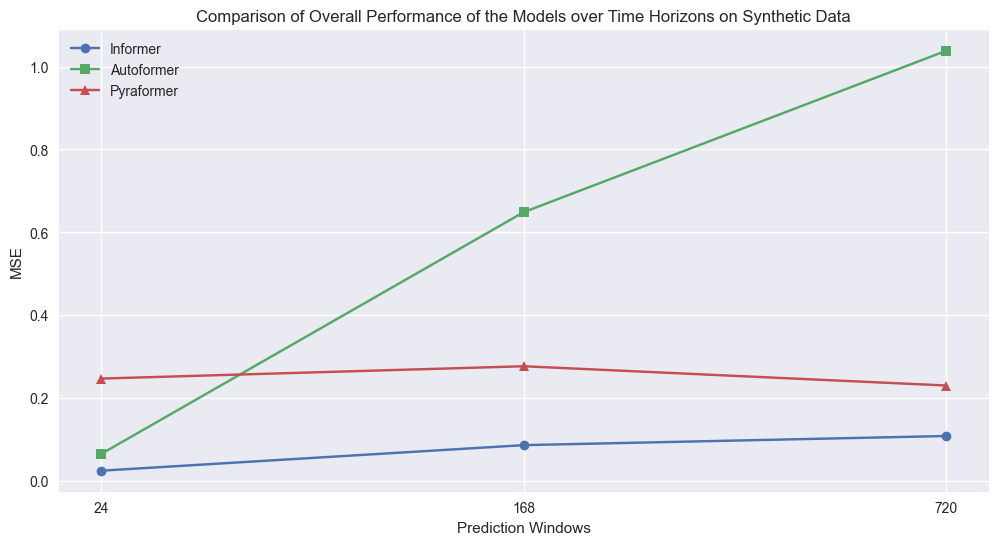

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(windows, errors_synthetic_informer, marker='o', label='Informer')
plt.plot(windows, errors_synthetic_autoformer, marker='s', label='Autoformer')
plt.plot(windows, errors_synthetic_pyraformer, marker='^', label='Pyraformer')
plt.xlabel('Prediction Windows')
plt.ylabel('MSE')
plt.title('Comparison of Overall Performance of the Models over Time Horizons on Synthetic Data')
plt.legend()
plt.show()
plt.close()

In [29]:
errors_wind_informer = [informer_windmetrics_24[1], informer_windmetrics_168[1], informer_windmetrics_720[1]]
errors_wind_autoformer = [autoformer_windmetrics_24[1], autoformer_windmetrics_168[1], autoformer_windmetrics_720[1]]
errors_synthetic_pyraformer = [0.420,0.257,0.272]

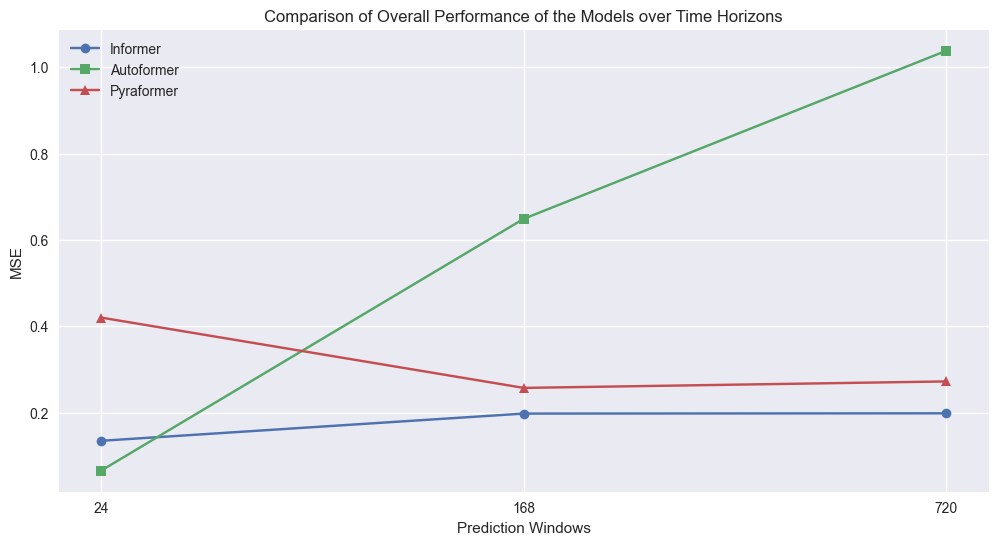

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(windows, errors_wind_informer, marker='o', label='Informer')
plt.plot(windows, errors_synthetic_autoformer, marker='s', label='Autoformer')
plt.plot(windows, errors_synthetic_pyraformer, marker='^', label='Pyraformer')
plt.xlabel('Prediction Windows')
plt.ylabel('MSE')
plt.title('Comparison of Overall Performance of the Models over Time Horizons')
plt.legend()
plt.show()
plt.close()

|  | Informer MSE | Informer MAE | Autoformer MSE | Autoformer MAE | Pyraformer MSE | Pyraformer MAE |
|---------|-------------|-------------|-------------|-------------|-------------|-------------|
| **SYNTHh1** 24 | 0.0249| 0.1256 | 0 | 0 | 0.2472 | 0.3454 |
| **SYNTHh1** 168 | 0.0866 | 0.2345 | 0 | 0 | 0.2770 | 0.4032 |
| **SYNTHh1** 720 | 0.1087 | 0.2599 | 0 | 0 | 0.2305 | 0.3644 |
| **DEWINDh_small** 24 | 0.1344 | 0.2046 | 0 | 0 | 0.420 | 0.1639 |
| **DEWINDh_small** 168 | 0.1975 | 0.2817 | 0 | 0 | 0.257 | 0.1237 |
| **DEWINDh_small** 720 | 0.1981 | 0.2627 | 0 | 0 |0.272 | 0.1279|


## **References**

[1] S. Liu, H. Yu, C. Liao, J. Li, W. Lin, A. X. Liu, and S. Dustdar, “Pyraformer: Low-Complexity Pyramidal Attention for Long-Range Time Series Modeling and Forecasting,” 2022, publisher: TU Wien. [Online]. Available: https://repositum.tuwien.at/handle/20.500.12708/135874 <br>

[2] H. Zhou, S. Zhang, J. Peng, S. Zhang, J. Li, H. Xiong, and W. Zhang, “Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting,” Proceedings of the AAAI Conference on Artificial Intelligence, vol. 35, no. 12, pp. 11 106–11 115, May 2021. [Online]. Available:
https://ojs.aaai.org/index.php/AAAI/article/view/17325

[3] Haixu Wu, Jiehui Xu, Jianmin Wang, Mingsheng Long , "Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting" , 2022. [Online]. Available: https://arxiv.org/abs/2106.13008